# Plotting PyPSA results (adapted for the First Run of Bolivia - config.yaml file)

### Adele will check for additional results that can be used


In [127]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 0 folder(s) up.


In [128]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [129]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_10_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Solved network

In [130]:
n = n_solve

In [131]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,3.212464e-11,primary_energy,NaN,co2_emissions


In [132]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)


n.objective

308627449.9779482

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x17df7c231f0>,
 <matplotlib.collections.LineCollection at 0x17df7c64700>)

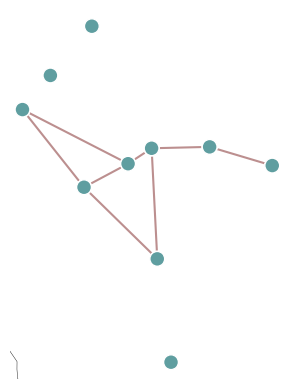

In [133]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"


n.plot()

In [134]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (6h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

624

### Overview components

In [135]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 8 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 46 entries
Component 'Store' has 20 entries


### Energy balance

In [136]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO 0 H2         1.818989e-12
BO 1 H2         3.176374e-22
BO 2 H2         2.117582e-22
BO 3 H2         2.646978e-23
BO 4 H2         7.940934e-23
BO 5 H2        -2.382280e-22
BO 6 H2        -1.852885e-22
BO 7 H2         4.499863e-22
BO 8 H2         7.105427e-14
BO 9 H2         1.136868e-13
BO 0 battery    4.235165e-22
BO 1 battery    1.124966e-22
BO 2 battery   -1.654361e-23
BO 3 battery   -1.191140e-22
BO 4 battery    5.624828e-23
BO 5 battery    7.279189e-23
BO 6 battery    4.963084e-23
BO 7 battery   -5.955700e-23
BO 8 battery   -3.044025e-22
BO 9 battery   -2.646978e-21
dtype: float64

In [137]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 


n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'p_nom_extendable', 'carrier', 'bus',
       'max_hours', 'efficiency_dispatch', 'efficiency_store',
       'cyclic_state_of_charge', 'control', 'p_nom_opt', 'sign', 'build_year',
       'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before',
       'type', 'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime',
       'committable', 'start_up_cost', 'shut_down_cost', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,carrier,bus,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 biomass,inf,0.000000,4.940000e+00,278015.359506,0.468,4.940000,14.967412,False,biomass,BO 0,NaN,NaN,NaN,NaN,Slack,4.940000e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 oil,inf,0.000000,1.174000e+01,38234.561404,0.393,11.740000,130.236450,False,oil,BO 0,NaN,NaN,NaN,NaN,,1.174000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,7.178415e+05,28760.831046,5.604937e+00,109295.569252,1.000,5.604937,0.025117,True,onwind,BO 0,NaN,NaN,NaN,NaN,,5.604937e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,3.910029e+05,52379.941288,1.938137e+01,50855.958267,1.000,19.381369,0.020474,True,solar,BO 0,NaN,NaN,NaN,NaN,,2.911701e+03,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,inf,0.000000,3.839800e+02,84469.122809,0.500,383.980000,47.210559,True,CCGT,BO 1,NaN,NaN,NaN,NaN,Slack,3.839800e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,4.980600e+02,47234.561404,0.390,498.060000,58.393773,True,OCGT,BO 1,NaN,NaN,NaN,NaN,,4.980600e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 biomass,inf,0.000000,7.229000e+01,278015.359506,0.468,72.290000,14.967093,False,biomass,BO 1,NaN,NaN,NaN,NaN,,7.229000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.024107,True,onwind,BO 1,NaN,NaN,NaN,NaN,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.020497,True,solar,BO 1,NaN,NaN,NaN,NaN,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [138]:
#Imprimir solo los generadores de Bolivia

########(this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,carrier,bus,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 biomass,inf,0.000000,4.940000e+00,278015.359506,0.468,4.940000,14.967412,False,biomass,BO 0,NaN,NaN,NaN,NaN,Slack,4.940000e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 oil,inf,0.000000,1.174000e+01,38234.561404,0.393,11.740000,130.236450,False,oil,BO 0,NaN,NaN,NaN,NaN,,1.174000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,7.178415e+05,28760.831046,5.604937e+00,109295.569252,1.000,5.604937,0.025117,True,onwind,BO 0,NaN,NaN,NaN,NaN,,5.604937e+00,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,3.910029e+05,52379.941288,1.938137e+01,50855.958267,1.000,19.381369,0.020474,True,solar,BO 0,NaN,NaN,NaN,NaN,,2.911701e+03,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,inf,0.000000,3.839800e+02,84469.122809,0.500,383.980000,47.210559,True,CCGT,BO 1,NaN,NaN,NaN,NaN,Slack,3.839800e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,4.980600e+02,47234.561404,0.390,498.060000,58.393773,True,OCGT,BO 1,NaN,NaN,NaN,NaN,,4.980600e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 biomass,inf,0.000000,7.229000e+01,278015.359506,0.468,72.290000,14.967093,False,biomass,BO 1,NaN,NaN,NaN,NaN,,7.229000e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.024107,True,onwind,BO 1,NaN,NaN,NaN,NaN,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.020497,True,solar,BO 1,NaN,NaN,NaN,NaN,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [139]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

####### Data was not yet updated and therefore a big difference between real capacities in 2020 (largely oversized) and optimized installed capacities (relatively low changes)
# - To change this, additional plants have to be added to better represent the system

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

10000003235.204435

In [140]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


147928.32566070464

### Total installed generator capacity

In [141]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18708\2958603594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.029050e+03,2.534074e+05,1.500,1029.050000,141.630013,3,0.0,0.0,0.0,0.0,1.029050e+03,3.00,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
OCGT,NaN,0.000000,1.239830e+03,2.361728e+05,1.950,1239.830000,291.974029,5,0.0,0.0,0.0,0.0,1.239830e+03,5.00,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
biomass,NaN,0.000000,7.723000e+01,5.560307e+05,0.936,77.230000,29.934505,0,0.0,0.0,0.0,0.0,7.723000e+01,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
hydro,NaN,0.000000,7.322000e+02,0.000000e+00,5.000,0.000000,0.049152,0,0.0,0.0,0.0,0.0,7.322000e+02,5.00,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
load,NaN,0.000000,1.000000e+10,0.000000e+00,10.000,0.000000,10.097486,0,0.0,0.0,0.0,0.0,1.000000e+10,0.01,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
oil,inf,0.000000,1.174000e+01,3.823456e+04,0.393,11.740000,130.236450,0,0.0,0.0,0.0,0.0,1.174000e+01,1.00,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.376047e+06,124486.370505,2.596471e+01,1.092956e+06,10.000,25.964709,0.247134,10,0.0,0.0,0.0,0.0,2.596471e+01,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
solar,1.869632e+06,324318.258522,1.191897e+02,5.085596e+05,10.000,119.189726,0.199429,10,0.0,0.0,0.0,0.0,4.097338e+03,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0


In [142]:
n.stores_t.p.head()

Store,BO 0 H2,BO 1 H2,BO 2 H2,BO 3 H2,BO 4 H2,BO 5 H2,BO 6 H2,BO 7 H2,BO 8 H2,BO 9 H2,BO 0 battery,BO 1 battery,BO 2 battery,BO 3 battery,BO 4 battery,BO 5 battery,BO 6 battery,BO 7 battery,BO 8 battery,BO 9 battery
snapshot,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,370.580203,2.252793e-08,2.248549e-08,2.255523e-08,2.253637e-08,2.255711e-08,2.252099e-08,2.255979e-08,4.808383,48.316709,2.127396e-07,3.720990e-10,3.633734e-10,3.668793e-10,3.715086e-10,3.704968e-10,3.647028e-10,3.660226e-10,1.022695e-07,1.733885e-09
2013-01-01 06:00:00,312.713838,2.222019e-08,2.207896e-08,2.228543e-08,2.224602e-08,2.226664e-08,2.203310e-08,2.226293e-08,4.111431,41.313428,2.123353e-07,6.681493e-09,6.689019e-09,6.691129e-09,6.684270e-09,6.685806e-09,6.678589e-09,6.677904e-09,1.027180e-07,4.952370e-09
2013-01-01 12:00:00,-501.022405,-8.490277e-08,-8.501353e-08,-8.493296e-08,-8.488501e-08,-8.492780e-08,-8.434419e-08,-8.491226e-08,-5.725980,-64.925345,-4.240057e-07,-1.378729e-08,-1.379627e-08,-1.378354e-08,-1.378124e-08,-1.378565e-08,-1.377668e-08,-1.377730e-08,-2.046185e-07,-8.896877e-10
2013-01-01 18:00:00,-373.111001,1.962667e-08,1.965110e-08,1.966809e-08,1.963423e-08,1.962242e-08,1.958024e-08,1.962943e-08,-2.303467,-48.020938,-1.069617e-09,6.736719e-09,6.733922e-09,6.741370e-09,6.731506e-09,6.731006e-09,6.739831e-09,6.738480e-09,-3.659567e-10,-6.910928e-09
2013-01-02 00:00:00,375.668741,1.773065e-08,1.779093e-08,1.778675e-08,1.775053e-08,1.775333e-08,1.773374e-08,1.776922e-08,4.861396,48.849413,2.127044e-07,1.743266e-10,1.914178e-10,1.780788e-10,1.819871e-10,1.843432e-10,1.749504e-10,1.772045e-10,1.021681e-07,3.951746e-09


<AxesSubplot:xlabel='snapshot'>

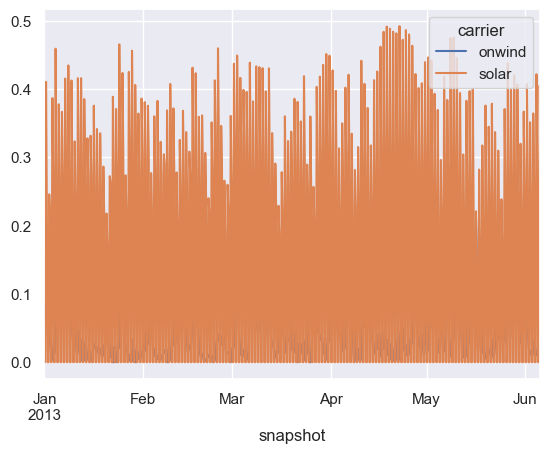

In [143]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [144]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [145]:
n.loads_t.p.sum().sum()

802471.0199702531

In [146]:
n.generators_t.p.sum().sum()

950399.3456309577

In [147]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BO 0  biomass    1.482000e-06
      load       3.000000e+02
      oil        3.522000e-06
      onwind     1.681481e-06
      solar      5.814411e-06
BO 1  CCGT       1.151940e-04
      OCGT       1.494180e-04
      biomass    2.168700e-05
      load       3.000000e+02
      onwind     3.656775e-06
      solar      3.380796e-06
BO 2  CCGT       7.449000e-05
      OCGT       6.014100e-05
      hydro      7.950000e-06
      load       3.000000e+02
      onwind     1.953577e-06
      solar      1.502944e-05
BO 3  hydro      6.900000e-06
      load       3.000000e+02
      onwind     3.121608e-07
      solar      6.799367e-06
BO 4  OCGT       1.477500e-05
      hydro      8.316900e-05
      load       3.000000e+02
      onwind     6.559479e-08
      solar      3.271149e-06
BO 5  CCGT       1.190310e-04
      OCGT       1.129920e-04
      load       3.000000e+02
      onwind     7.859891e-08
      solar      2.834468e-07
BO 6  OCGT       3.462300e-05
      hydro      5.744100e

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

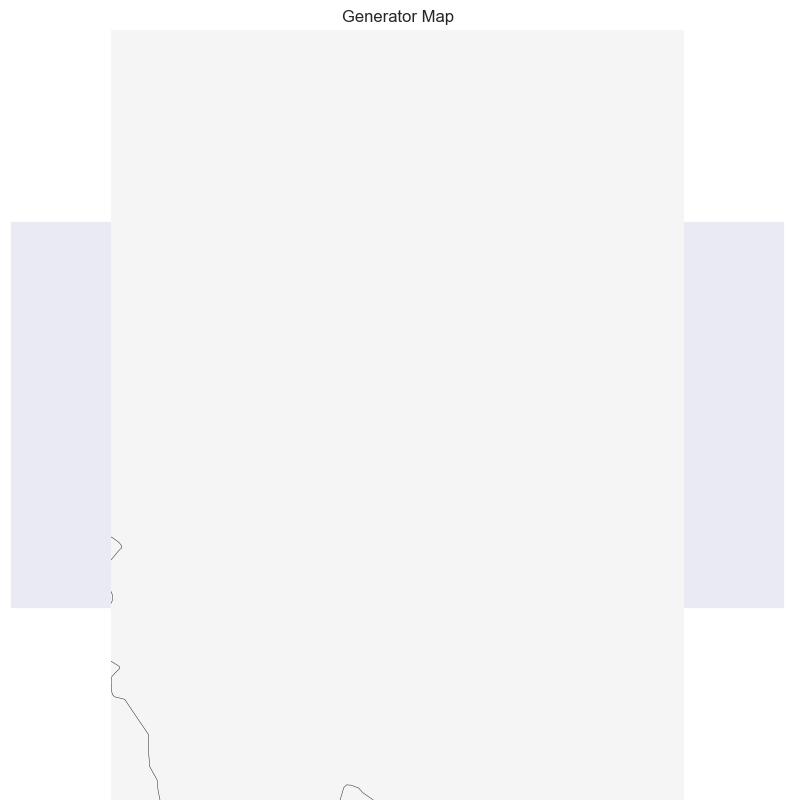

In [148]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [149]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    1.000003e+09
BO 1    1.000001e+09
BO 2    1.000001e+09
BO 3    1.000001e+09
BO 4    1.000000e+09
BO 5    1.000001e+09
BO 6    1.000000e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

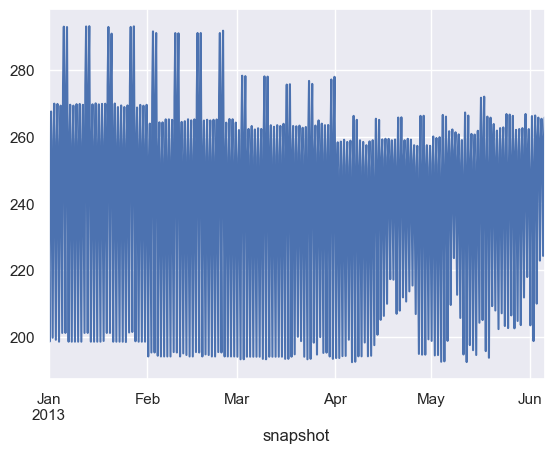

In [150]:
n.loads_t.p_set.loc["2013-01-01":"2013-06-06","BO 0"].plot()

In [151]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [152]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    149443.435993
BO 1    165760.688502
BO 2    198970.393846
BO 3     73000.693259
BO 4     81159.348527
BO 5     21354.765861
BO 6     30307.790539
BO 7     62642.610532
BO 8      1794.942286
BO 9     18036.350625
Name: load, dtype: float64

In [153]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    1.000003e+09
BO 1    1.000001e+09
BO 2    1.000001e+09
BO 3    1.000001e+09
BO 4    1.000000e+09
BO 5    1.000001e+09
BO 6    1.000000e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64

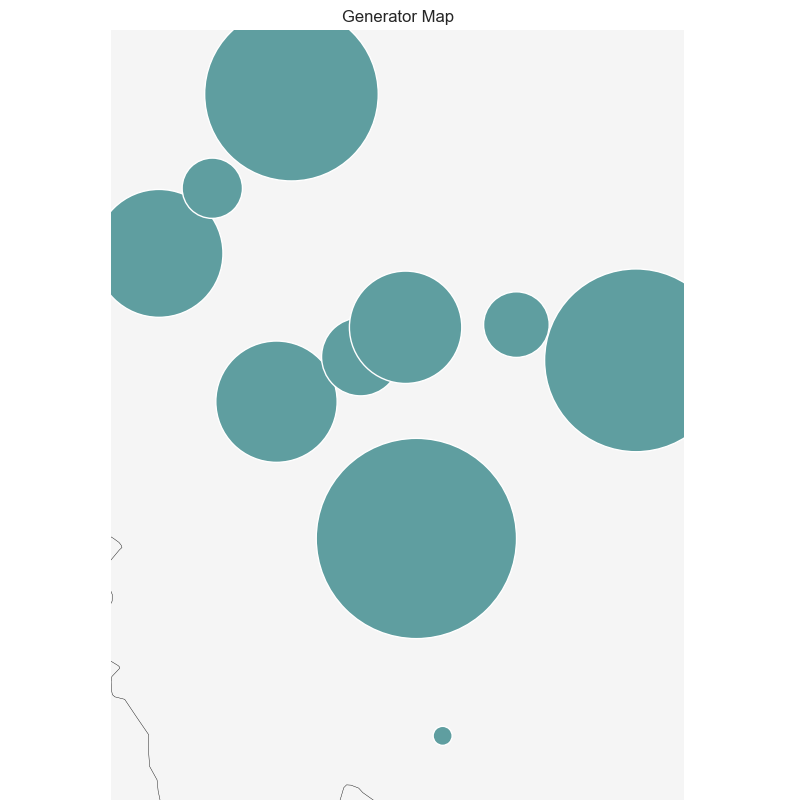

In [154]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [155]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  biomass    4.940000e+00
      load       1.000000e+09
      oil        1.174000e+01
      onwind     5.604937e+00
      solar      2.911701e+03
BO 1  CCGT       3.839800e+02
      OCGT       4.980600e+02
      biomass    7.229000e+01
      load       1.000000e+09
      onwind     1.218925e+01
      solar      1.126932e+01
BO 2  CCGT       2.483000e+02
      OCGT       2.004700e+02
      hydro      2.650000e+01
      load       1.000000e+09
      onwind     6.511923e+00
      solar      5.009812e+01
BO 3  hydro      2.300000e+01
      load       1.000000e+09
      onwind     1.040536e+00
      solar      6.256871e+02
BO 4  OCGT       4.925000e+01
      hydro      2.772300e+02
      load       1.000000e+09
      onwind     2.186490e-01
      solar      1.090383e+01
BO 5  CCGT       3.967700e+02
      OCGT       3.766400e+02
      load       1.000000e+09
      onwind     2.619960e-01
      solar      9.448230e-01
BO 6  OCGT       1.154100e+02
      hydro      1.914700e

### Plot of Average Marginal Price

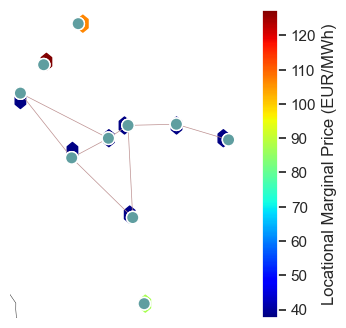

In [156]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

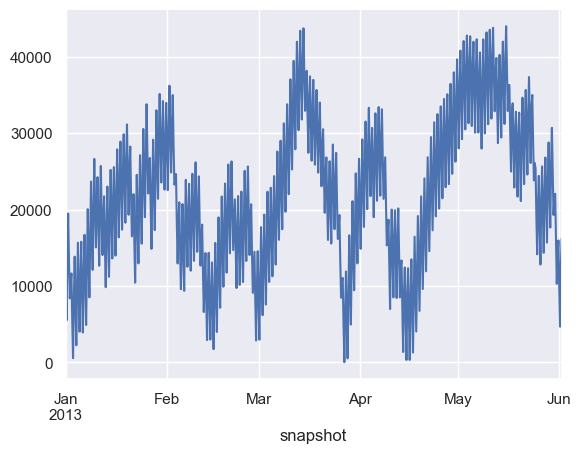

In [157]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [158]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       722.983895
H2 fuel cell          463.113579
battery charger         0.000003
battery discharger      0.000004
Name: p_nom_opt, dtype: float64